In [ ]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 98.5 MB/s eta 0:00:00


In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.2 MB/s eta 0:00:00


In [ ]:
!pip install pandas

In [ ]:
!pip install --upgrade pydantic

In [ ]:
!pip install protobuf==5.26.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/cap/gpay.pdf"


In [ ]:
import pdfplumber

with pdfplumber.open(file_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        print(text)  # Display extracted text


Google Pay
Paid ₹1518.00 to Amazon India using Bank Account XXXXXX3075
May 29, 2025, 9:28:36 PM GMT+05:30
Products:
Google Pay
Details:
RBA01971cc447f989802896ad3fca80dbc8
Completed
Google Pay
Paid ₹426.00 to Swiggy Limited using Bank Account XXXXXX3075
May 29, 2025, 6:47:45 PM GMT+05:30
Products:
Google Pay
Details:
AIR1Qal4UCMNoFK25ST2854691073QPAY02
Completed
Google Pay
Paid ₹421.00 to SWIGGY using Bank Account XXXXXX3075
May 29, 2025, 2:00:05 PM GMT+05:30
Products:
Google Pay
Details:
ICI3cb2483ee3284bd6969d1a7cc397e433
Completed
Google Pay
Paid ₹2706.00 to Max Retail using Bank Account XXXXXX3075
May 28, 2025, 4:52:12 PM GMT+05:30
Products:
Google Pay
Details:
Qqcj7GksT0SVpsAN
Completed
Google Pay
Received ₹2000.00
May 28, 2025, 4:08:22 PM GMT+05:30
Products:
Google Pay
Details:
4B/P7RTfQr28e6hU
Completed
Google Pay
Paid ₹200.00 to BARREL O FISH SPA using Bank Account XXXXXX3075
May 28, 2025, 4:04:44 PM GMT+05:30
Products:
Google Pay
Details:
kNBr0mHqRdyVHmaZ
Completed
Google Pay


In [ ]:
import re, pdfplumber, pandas as pd
import warnings, logging

# 1. Filter out the exact warning message
warnings.filterwarnings(
    "ignore",
    message="CropBox missing from /Page, defaulting to MediaBox"
)

# 2. Downgrade pdfminer logging verbosity
logging.getLogger("pdfminer").setLevel(logging.ERROR)

# 1) Load full text from PDF
file_path = "/content/drive/MyDrive/cap/gpay.pdf"
with pdfplumber.open(file_path) as pdf:
    full_text = "\n".join(page.extract_text() or "" for page in pdf.pages)

# 2) Regex: type, amount, optional receiver, full timestamp, tx-id, status
pattern = re.compile(
    r"(Received|Paid) ₹([\d,]+\.\d{2})"                # 1: Received/Paid + amount
    r"(?: to (.*?))?\s*\n"                            # 2: optional “to X”
    r"([A-Za-z]{3} \d{1,2}, \d{4}, \d{1,2}:\d{2}:\d{2} [APM]+) GMT"
                                                      # 3: full timestamp
    r".*?Details:\s*([\w/]+)\s*\n"                    # 4: Txn ID
    r"(Completed|Failed)",                           # 5: status
    re.DOTALL
)

matches = pattern.findall(full_text)
print(f"🔎 Found {len(matches)} transactions")

# 3) Build records
records = []
for ttype, amt_str, recv, ts_str, txid, status in matches:
    dt = pd.to_datetime(ts_str, format="%b %d, %Y, %I:%M:%S %p", errors="coerce")
    amt = float(amt_str.replace(",", ""))
    recv = recv or "Self (Received)"
    cat = "Income" if ttype == "Received" else "Expense"

    records.append({
        "datetime":     dt,
        "transaction_type": ttype,
        "is_income":    ttype == "Received",
        "is_expense":   ttype == "Paid",
        "amount":       amt,
        "raw_receiver": recv,
        "transaction_id": txid,
        "status":       status,
        "category":     cat
    })

df = pd.DataFrame(records)

# 4) Drop any rows where datetime parsing failed
df = df.dropna(subset=["datetime"])

# 5) Derive date parts
df["year"]       = df["datetime"].dt.year
df["month"]      = df["datetime"].dt.month
df["month_name"] = df["datetime"].dt.month_name()
df["day"]        = df["datetime"].dt.day
df["weekday"]    = df["datetime"].dt.day_name()

# 6) Clean up merchant names & map to spend categories
df["merchant"] = (
    df["raw_receiver"]
      .str.replace(r" using Bank Account.*", "", regex=True)
      .str.title()
)

category_map = {
    "Swiggy":           "Food Delivery",
    "Swiggy Instamart": "Groceries",
    "Barrel O Fish Spa":"Wellness",
    # add your own mappings here
}
df["spend_category"] = df["merchant"].map(category_map).fillna("Other")

# 7) Final ordering & dedupe
cols = [
  "datetime","year","month","month_name","day","weekday",
  "transaction_type","is_expense","is_income",
  "amount","merchant","spend_category","status","transaction_id"
]
df = df.drop_duplicates(subset=["transaction_id"])[cols].sort_values("datetime")

# 8) Save to CSV
out_path = "structured_transactions.csv"
df.to_csv(out_path, index=False)
print(f"✅ Saved {len(df)} records to {out_path}")

🔎 Found 270 transactions
✅ Saved 270 records to structured_transactions.csv


In [ ]:
import pandas as pd

df = pd.read_csv("structured_transactions.csv", parse_dates=["datetime"])
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          270 non-null    datetime64[ns]
 1   year              270 non-null    int64         
 2   month             270 non-null    int64         
 3   month_name        270 non-null    object        
 4   day               270 non-null    int64         
 5   weekday           270 non-null    object        
 6   transaction_type  270 non-null    object        
 7   is_expense        270 non-null    bool          
 8   is_income         270 non-null    bool          
 9   amount            270 non-null    float64       
 10  merchant          270 non-null    object        
 11  spend_category    270 non-null    object        
 12  status            270 non-null    object        
 13  transaction_id    270 non-null    object        
dtypes: bool(2), datetime64[ns]

In [ ]:
# Total income vs expenses
totals = df.groupby("transaction_type").amount.sum()
print(totals)

# Top 5 merchants by spend
spend = df[df.is_expense].groupby("merchant").amount.sum().sort_values(ascending=False)
print(spend.head(5))


transaction_type
Paid        142296.27
Received    124745.00
Name: amount, dtype: float64
merchant
Vummidi Bangaru Jewellers India Private\nLimited    32200.00
Swiggy                                              14365.00
Swiggy Instamart                                     8978.00
Amazon Pay Balance                                   6500.00
Amazon Pay                                           5311.39
Name: amount, dtype: float64


In [ ]:
monthly = (
    df[df.is_expense]
      .groupby([df.datetime.dt.to_period("M"), "spend_category"])
      .amount.sum()
      .unstack(fill_value=0)
)
print(monthly.tail())


spend_category  Food Delivery  Groceries     Other  Wellness
datetime                                                    
2025-01                1038.0      557.0  13019.64       0.0
2025-02                3300.0     2680.0  14090.42       0.0
2025-03                3285.0     2853.0  19892.19       0.0
2025-04                3158.0     1384.0  17413.55       0.0
2025-05                3584.0     1504.0  54337.47     200.0


<Axes: title={'center': 'Monthly Expenses by Category'}, xlabel='datetime'>

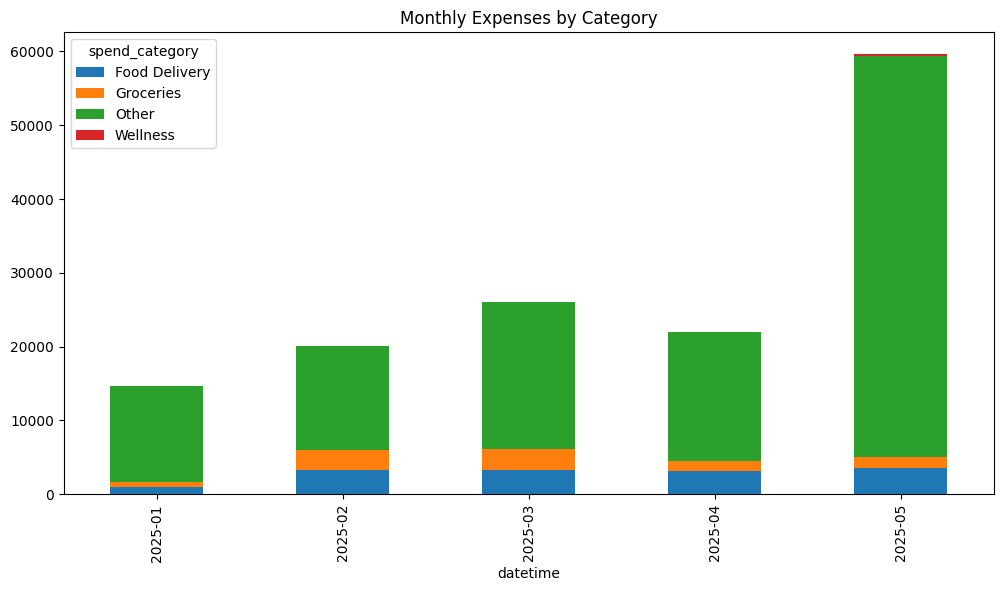

In [ ]:
monthly.plot(kind="bar", stacked=True, figsize=(12,6), title="Monthly Expenses by Category")


In [ ]:
# load your cleaned DataFrame
import pandas as pd
df = pd.read_csv("structured_transactions.csv", parse_dates=["datetime"])

# filter only expense & “Other”
other = (
    df[df.is_expense & (df.spend_category=="Other")]
      .groupby("merchant")
      .amount.sum()
      .sort_values(ascending=False)
)
print(other.head(40))


merchant
Vummidi Bangaru Jewellers India Private\nLimited                         32200.00
Amazon Pay Balance                                                        6500.00
Amazon Pay                                                                5311.39
Zepto                                                                     4744.55
Giriasmogappairwest                                                       4200.00
Amazon India                                                              3843.00
Chennai Water (Cmwssb)\nXxxxxx3075                                        3649.00
Airtel Prepaid                                                            3633.30
Lanson Motors Private Limited\nXxxxxx3075                                 2971.00
Tamil Nadu Electricity (Tneb)\nXxxxxx3075                                 2909.00
Thiruvalluvar Salai Mugappair East Using Bank\nAccount Xxxxxx3075         2805.50
Max Retail                                                                2706.00
Bharti 

In [ ]:
import pandas as pd

# 1) Load your DataFrame
df = pd.read_csv("structured_transactions.csv", parse_dates=["datetime"])

# 2) Create a clean_merchant field
df["clean_merchant"] = (
    df["merchant"]
      .str.replace(r"\n.*", "", regex=True)   # drop newline + everything after
      .str.strip()                             # trim spaces
)

# 3) Check what the Vummidi name looks like now
print(df[df["clean_merchant"].str.contains("Vummidi")]["clean_merchant"].unique())
# e.g. ['Vummidi Bangaru Jewellers India Private Limited']

# 4) Update your category map to use the cleaned name
category_map = {
    "Vummidi Bangaru Jewellers India Private": "Jewellery",
    "Amazon Pay Balance":      "Shopping",
    "Amazon Pay":              "Shopping",
    "Amazon Pay Groceries":    "Groceries",
    "Snapdeal":                "Shopping",
    "Libas":                   "Shopping",
    "Zepto":                   "Groceries",
    "Giriasmogappairwest":     "Home Appliances",
    "Amazon India":            "Shopping",
    "Chennai Water (Cmwssb)":  "Utilities: Water",
    "Tamil Nadu Electricity (Tneb)": "Utilities: Electricity",
    "Airtel Prepaid":          "Telecom & Recharge",
    "Lanson Motors Private Limited": "Automobile",
    "Thiruvalluvar Salai Mugappair East": "Shopping",
    "Max Retail":              "Shopping",
    "Bharti Airtel Limited":   "Telecom & Recharge",
    "Flipkart Internet Groceries": "Groceries",
    "Amman Foods":             "Food Delivery",
    "Ligo Super Speciality Hospitals": "Healthcare",
    "Mr Yuvaraj J":            "Groceries: Meat & Seafood",
    "Good To Go":              "Food Delivery"
}

# 5) Map using clean_merchant, falling back to existing spend_category
df["spend_category"] = (
    df["clean_merchant"]
      .map(category_map)
      .fillna(df["spend_category"])
)

# 6) Re-pivot to confirm “Jewellery” shows up in May
monthly = (
    df[df.is_expense]
      .groupby([df.datetime.dt.to_period("M"), "spend_category"])
      .amount.sum()
      .unstack(fill_value=0)
)
print(monthly.loc["2025-05"])


['Vummidi Bangaru Jewellers India Private']
spend_category
Automobile                       0.00
Food Delivery                 3584.00
Groceries                     4803.26
Groceries: Meat & Seafood      900.00
Healthcare                     100.00
Home Appliances                  0.00
Jewellery                    32200.00
Other                         4700.31
Shopping                      4868.00
Telecom & Recharge             300.90
Utilities: Electricity        4320.00
Utilities: Water              3649.00
Wellness                       200.00
Name: 2025-05, dtype: float64


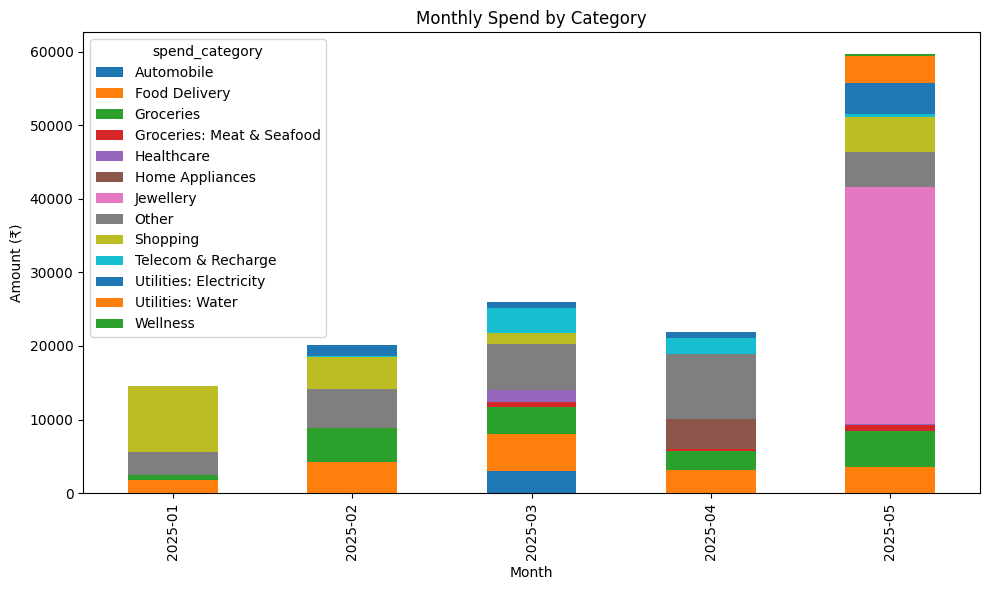

In [ ]:
import matplotlib.pyplot as plt

monthly.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Monthly Spend by Category")
plt.xlabel("Month")
plt.ylabel("Amount (₹)")
plt.tight_layout()
plt.show()


In [ ]:
# 1) Filter May-2025 + expenses still in “Other”
mask = (
    (df.datetime.dt.to_period("M") == "2025-05")
    & df.is_expense
    & (df.spend_category == "Other")
)
may_other = df[mask]

# 2) Sum by merchant
others_breakdown = (
    may_other
      .groupby("clean_merchant")
      .amount
      .sum()
      .sort_values(ascending=False)
)
print(others_breakdown)


clean_merchant
Good To Go Foodworks Private Limited             790.00
Thiruvalluvar Salai Mugappair East Using Bank    711.50
Pvr Inox Limited                                 700.00
Zepto Marketplace Private Limited Using Bank     570.81
M/S.Ligo Pharmacy                                535.00
Swiggy Limited                                   426.00
Aladiyan Karupatti Shop                          280.00
Medplus Padi Kumaran Nagar                       176.00
Zepto Marketplace Private Limited                160.00
Punitha Rani R                                   120.00
M/S.Saravana Egg Mart                             77.00
Rollbaby Roll Vr Mall                             70.00
Phonepe                                           44.00
M Jayabharathi                                    40.00
Name: amount, dtype: float64


In [ ]:
# 1) Your existing cleaned DataFrame
import pandas as pd

df = pd.read_csv("structured_transactions.csv", parse_dates=["datetime"])
df["clean_merchant"] = (
    df["merchant"]
      .str.replace(r"\n.*", "", regex=True)
      .str.strip()
)

# 2) Define just the new mappings for those last 14 merchants
mapping_updates = {
    "Good To Go Foodworks Private Limited": "Food Delivery",
    "Thiruvalluvar Salai Mugappair East":   "Shopping",
    "Pvr Inox Limited":                     "Entertainment: Movies",
    "Zepto Marketplace Private Limited":    "Groceries",
    "M/S.Ligo Pharmacy":                    "Healthcare: Pharmacy",
    "Swiggy Limited":                       "Food Delivery",
    "Aladiyan Karupatti Shop":              "Groceries",
    "Medplus Padi Kumaran Nagar":           "Healthcare: Pharmacy",
    "Punitha Rani R":                       "Personal Transfer",
    "M/S.Saravana Egg Mart":                "Groceries",
    "Rollbaby Roll Vr Mall":                "Food & Dining",
    "Phonepe":                              "Telecom & Recharge",
    "M Jayabharathi":                       "Personal Transfer"
}

# 3) Merge into your main category_map
#    (Assumes you already have `category_map` loaded from before)
category_map.update(mapping_updates)

# 4) Re-apply the mapping, fallback to existing spend_category
df["spend_category"] = (
    df["clean_merchant"]
      .map(category_map)
      .fillna(df["spend_category"])
)

# 5) Re-pivot to see May broken down completely
monthly = (
    df[df.is_expense]
      .groupby([df.datetime.dt.to_period("M"), "spend_category"])
      .amount.sum()
      .unstack(fill_value=0)
)

print(monthly.loc["2025-05"])


spend_category
Automobile                       0.00
Entertainment: Movies          700.00
Food & Dining                   70.00
Food Delivery                 4800.00
Groceries                     5320.26
Groceries: Meat & Seafood      900.00
Healthcare                     100.00
Healthcare: Pharmacy           711.00
Home Appliances                  0.00
Jewellery                    32200.00
Other                         1282.31
Personal Transfer              160.00
Shopping                      4868.00
Telecom & Recharge             344.90
Utilities: Electricity        4320.00
Utilities: Water              3649.00
Wellness                       200.00
Name: 2025-05, dtype: float64


In [ ]:
import pandas as pd

# reload your DataFrame (with clean_merchant & existing spend_category)
df = pd.read_csv("structured_transactions.csv", parse_dates=["datetime"])
df["clean_merchant"] = (
    df["merchant"]
      .str.replace(r"\n.*", "", regex=True)
      .str.strip()
)

# filter everything still labeled “Other”
others = (
    df[df.spend_category == "Other"]
      .groupby("clean_merchant")
      .amount
      .sum()
      .sort_values(ascending=False)
)

print("Merchants still in ‘Other’:")
print(others)


Merchants still in ‘Other’:
clean_merchant
Self (Received)                            124745.00
Vummidi Bangaru Jewellers India Private     32200.00
Tamil Nadu Electricity (Tneb)                7443.00
Amazon Pay Balance                           6500.00
Amazon Pay                                   5311.39
                                             ...    
Phonepe                                        44.00
17998 Apollo Pharmacy                          43.75
Cashfree Payments                              39.55
Airtel Payments Bank Limited                   22.00
Zerodha Broking Ltd                             3.00
Name: amount, Length: 81, dtype: float64


In [ ]:
import pandas as pd

# 1) Load your cleaned data
df = pd.read_csv("structured_transactions.csv", parse_dates=["datetime"])

# 2) Spending patterns
total_spent = df[df.is_expense].amount.sum()
top_categories = (
    df[df.is_expense]
      .groupby("spend_category").amount.sum()
      .sort_values(ascending=False)
      .head(3)
      .to_dict()
)

# 3) Time-based trends (last 3 months)
trend = (
    df[df.is_expense]
      .groupby(df.datetime.dt.to_period("M"))
      .amount.sum()
      .tail(3)
      .to_dict()
)

# 4) Wasteful transaction detection (e.g., single-payments >75th percentile)
threshold = df[df.is_expense].amount.quantile(0.75)
wasteful = df[(df.is_expense) & (df.amount > threshold)][
    ["datetime","merchant","amount"]
].to_dict(orient="records")


In [ ]:
# Install the necessary community package for LangChain
!pip install langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install -q transformers accelerate langchain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00


In [ ]:
!pip install -U langchain langchain-core langchain-huggingface transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.72
    Uninstalling langchain-core-0.3.72:
      Successfully uninstalled langchain-core-0.3.72


In [ ]:
from huggingface_hub import login

# Paste your token here
login("")


In [ ]:
# ─── Imports ───
import pandas as pd
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline

# ─── Step 0: Load and Clean the Data ───
df = pd.read_csv("structured_transactions.csv", parse_dates=["datetime"])
df["clean_merchant"] = (
    df["merchant"]
      .str.replace(r"\n.*", "", regex=True)
      .str.strip()
)

# ─── Step 1: Metrics ───
total_spent = df[df.is_expense].amount.sum()

top_categories = (
    df[df.is_expense]
      .groupby("spend_category")
      .amount.sum()
      .sort_values(ascending=False)
      .head(3)
      .to_dict()
)

trend = (
    df[df.is_expense]
      .groupby(df.datetime.dt.to_period("M"))
      .amount.sum()
      .to_dict()
)

threshold = df[df.is_expense].amount.quantile(0.75)
wasteful = (
    df[(df.is_expense) & (df.amount > threshold)]
      .loc[:, ["datetime","clean_merchant","amount"]]
      .to_dict(orient="records")
)

# ─── Step 2: Compact Strings ───
top2 = list(top_categories.items())[:2]
top2_cat_str = "\n".join(f"- {cat}: ₹{amt}" for cat, amt in top2)

months = sorted(trend.keys())
if len(months) >= 2:
    prev, last = months[-2], months[-1]
    delta = trend[last] - trend[prev]
    trend_delta = f"₹{abs(delta):.2f} {'↑' if delta>0 else '↓'}"
else:
    trend_delta = "N/A"

top_waste = sorted(wasteful, key=lambda r: r["amount"], reverse=True)[:3]
wasteful_str = "\n".join(
    f"- {r['datetime'].strftime('%Y-%m-%d')}: {r['clean_merchant']} (₹{r['amount']})"
    for r in top_waste
)

# ─── Step 3: Build Prompt ───
template = """
You are a sharp personal finance coach. Your job is to convert spending data into clear, actionable advice.

Facts:
- Total spent: ₹{total_spent}
- Top categories:
{top2_cat_str}
- Trend change: ₹{trend_delta}
- High-value transactions:
{wasteful_str}

Instructions:
A) Give two behavioral insights based on spending patterns.
B) Suggest one practical way to reduce monthly spend.
C) Recommend one bold action for long-term financial control.

Format your response in markdown with clear headings and bullet points.
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["total_spent", "top2_cat_str", "trend_delta", "wasteful_str"]
)

model_id = "mistralai/Mistral-7B-Instruct-v0.1"

# ─── Step 4: Load Mistral Locally ───
hf_pipe = pipeline(
    "text-generation",
    model=model_id,
    tokenizer=model_id,
    device_map="auto",
    trust_remote_code=True
)

llm = HuggingFacePipeline(pipeline=hf_pipe)

chain = prompt | llm

# ─── Step 5: Run Chain with Error Handling ───
try:
    out = chain.invoke({
        "total_spent": total_spent,
        "top2_cat_str": top2_cat_str,
        "trend_delta": trend_delta,
        "wasteful_str": wasteful_str
    })

    # ─── Step 6: Display Final Advice ───
    print("### 💡 Personalized Financial Advice\n")
    print(out.strip())

except Exception as e:
    import traceback
    print("⚠️ Error generating advice:")
    traceback.print_exc()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### 💡 Personalized Financial Advice

You are a sharp personal finance coach. Your job is to convert spending data into clear, actionable advice.

Facts:
- Total spent: ₹142296.27000000002
- Top categories:
- Other: ₹118753.27
- Food Delivery: ₹14365.0
- Trend change: ₹₹37669.92 ↑
- High-value transactions:
- 2025-05-12: Vummidi Bangaru Jewellers India Private (₹32200.0)
- 2025-01-30: Amazon Pay Balance (₹6500.0)
- 2025-04-15: Giriasmogappairwest (₹4200.0)

Instructions:
A) Give two behavioral insights based on spending patterns.
B) Suggest one practical way to reduce monthly spend.
C) Recommend one bold action for long-term financial control.

Format your response in markdown with clear headings and bullet points.

# A) Behavioral Insights Based on Spending Patterns

1. **Lack of budgeting skills:** The majority of the spending is categorized under "Other," which suggests a lack of budgeting skills or an inability to prioritize expenses. This could lead to overspending on non-essential